In [1]:
%load_ext autoreload
%autoreload 2
from ridge_utils.DataSequence import DataSequence
import pandas as pd
import matplotlib.pyplot as plt
from os.path import dirname
import os
from tqdm import tqdm
from neuro.features import qa_questions, feature_spaces
from neuro.data import story_names, response_utils
from neuro.features.stim_utils import load_story_wordseqs, load_story_wordseqs_huge
import neuro.config
import seaborn as sns
from neuro.features.questions.gpt4 import QS_35_STABLE
import numpy as np
import joblib
from collections import defaultdict
from os.path import join
from sklearn.metrics import balanced_accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegressionCV
from neuro import analyze_helper
import dvu
from copy import deepcopy
dvu.set_style()
data_dir = join(neuro.config.repo_dir, 'data', 'decoding')

In [2]:
def get_fmri_and_labs(data_dir, story_name='onapproachtopluto', train_or_test='test', subject='uts03'):
    '''
    Returns
    -------
    df : pd.DataFrame
        The fMRI features, with columns corresponding to the principal components
        of the fMRI data.
    labs : pd.DataFrame
        Binary labeled annotations for each of the texts
    texts: 
        The texts corresponding to the rows of df
    '''
    df = joblib.load(
        join(data_dir, subject, train_or_test, story_name + '.pkl'))
    dfs = []
    for offset in [1, 2, 3, 4]:
        df_offset = df.shift(-offset)
        df_offset.columns = [col + f'_{offset}' for col in df.columns]
        dfs.append(df_offset)
    df = pd.concat(dfs, axis=1)  # .dropna()  # would want to dropna here

    # load labels
    labs = joblib.load(
        join(data_dir, 'labels', train_or_test, story_name + '_labels.pkl'))

    # drop rows with nans
    idxs_na = df.isna().sum(axis=1).values > 0
    df = df[~idxs_na]
    labs = labs[~idxs_na]
    texts = pd.Series(df.index)
    return df, labs, texts


def concatenate_running_texts(texts, frac=1/2):
    '''When decoding, you might want to concatenate 
    the text of the current and surrounding texts
    to deal with the temporal imprecision of the fMRI signal.
    '''
    texts_before = (
        texts.shift(1)
        .str.split().apply(  # only keep second half of words
            lambda l: ' '.join(l[int(-len(l) * frac):]) if l else '')
    )

    texts_after = (
        texts.shift(-1)
        .str.split().apply(  # only keep first half of words
            lambda l: ' '.join(l[:int(len(l) * frac)]) if l else '')
    )

    return texts_before + ' ' + texts + ' ' + texts_after

# example get data
# df_orig, labs, texts = get_fmri_and_labs(data_dir)
# texts = concatenate_running_texts(texts)

# Run decode for all questions

In [ ]:
# load all the data for a single subject
data_by_subject = {}
for subject in ['uts01', 'uts02', 'uts03']:
    data = defaultdict(list)
    for train_or_test in ['test', 'train']:
        story_names_list = os.listdir(join(data_dir, subject, train_or_test))
        for story_name in story_names_list:
            df, labs, texts = get_fmri_and_labs(
                data_dir, story_name.replace('.pkl', ''), train_or_test, subject)
            data['df_' + train_or_test].append(df)
            data['labs_' + train_or_test].append(labs)
            data['texts_' + train_or_test].append(texts)

    for k in data:
        data[k] = pd.concat(data[k], axis=0)
    data_by_subject[subject] = data

In [30]:
# set to None to keep all coefs
num_coefs_to_keep = None


def _keep_only_few_coefs(X, num_coefs_to_keep, num_features=200, num_delays=4):
    if num_coefs_to_keep is None:
        return X
    else:
        idxs_to_keep = np.arange(num_coefs_to_keep)
        idxs_to_keep = np.concatenate(
            [idxs_to_keep + i * num_features for i in range(num_delays)])
        return X[:, idxs_to_keep]


for subject in ['uts01', 'uts02', 'uts03'][::-1]:
    data = data_by_subject[subject]

    # example fit linear decoder
    r = defaultdict(list)
    for label_num in tqdm(range(data['labs_train'].shape[1])):
        X_train, y_train = data['df_train'].values, data['labs_train'].values[:, label_num]
        X_test, y_test = data['df_test'].values, data['labs_test'].values[:, label_num]
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

        # balance the binary class imbalance
        try:
            rus = RandomUnderSampler(random_state=42)
            X_train, y_train = rus.fit_resample(X_train, y_train)
            X_test, y_test = rus.fit_resample(X_test, y_test)

            # only keep 5 feats
            X_train = _keep_only_few_coefs(X_train, num_coefs_to_keep)
            X_test = _keep_only_few_coefs(X_test, num_coefs_to_keep)

            if len(y_test) < 30:
                print('too few positive labels', label_num)
                continue

            print('label', label_num,
                  data['labs_train'].columns[label_num], X_train.shape, X_test.shape)
            m = LogisticRegressionCV(random_state=42)
            m.fit(X_train, y_train)
            test_acc = m.score(X_test, y_test)
            print(
                f"""\ttest acc {test_acc:.3f}""")  # \n\tnaive acc {1 -y_test.mean():.3f}""")
            r['label'].append(data['labs_train'].columns[label_num])
            # y_pred = m.predict(X_test)
            # balanced_accuracy_score(y_test, y_pred))
            r['test_acc'].append(test_acc)
            r['num_test'].append(len(y_test))
            r['coef'].append(m.coef_.copy())

            # extra test data from another subject ##########
            test_acc_ood = []
            for subject_ood in ['uts01', 'uts02', 'uts03']:
                if subject_ood == subject:
                    continue
                X_test_ood, y_test_ood = data_by_subject[subject_ood][
                    'df_test'].values, data_by_subject[subject_ood]['labs_test'].values[:, label_num]

                # balance the binary class imbalance
                rus = RandomUnderSampler(random_state=42)
                X_test_ood, y_test_ood = rus.fit_resample(
                    X_test_ood, y_test_ood)

                X_test_ood = _keep_only_few_coefs(
                    X_test_ood, num_coefs_to_keep)

                test_acc_ood_subject = m.score(X_test_ood, y_test_ood)
                test_acc_ood.append(test_acc_ood_subject)
            r['test_acc_ood'].append(np.mean(test_acc_ood))

            print(f"""\ttest acc ood {np.mean(test_acc_ood):.3f}""")
            ###############################################

        except Exception as e:
            print(e)
            print('error for', label_num)
            continue
    r_df = pd.DataFrame(r)
    # .sort_values(
    # metric, ascending=False).reset_index()
    r_df.to_pickle(join(data_dir, f'r_df_{subject}.pkl'))

 72%|███████▏  | 62/86 [1:04:11<32:06, 80.27s/it]

	test acc 0.602
	test acc ood 0.500
(33484, 800) (33484,) (898, 800) (898,)
label 62 Does the sentence involve a description of physical environment or setting? (9406, 800) (318, 800)


 73%|███████▎  | 63/86 [1:05:08<28:11, 73.56s/it]

	test acc 0.689
	test acc ood 0.429
(33484, 800) (33484,) (898, 800) (898,)
label 63 Does the sentence involve a discussion about personal or social values? (6758, 800) (106, 800)


 74%|███████▍  | 64/86 [1:05:59<24:27, 66.71s/it]

	test acc 0.698
	test acc ood 0.434
(33484, 800) (33484,) (898, 800) (898,)
label 64 Does the sentence involve a recount of a social or community event? (4302, 800) (100, 800)


 76%|███████▌  | 65/86 [1:07:09<23:38, 67.57s/it]

	test acc 0.720
	test acc ood 0.460
(33484, 800) (33484,) (898, 800) (898,)
label 65 Does the sentence involve an expression of personal values or beliefs? (7888, 800) (162, 800)


 77%|███████▋  | 66/86 [1:07:58<20:41, 62.05s/it]

	test acc 0.673
	test acc ood 0.451
(33484, 800) (33484,) (898, 800) (898,)
label 66 Does the sentence involve an unexpected incident or accident? (4580, 800) (148, 800)


 78%|███████▊  | 67/86 [1:09:01<19:44, 62.35s/it]

	test acc 0.561
	test acc ood 0.436
(33484, 800) (33484,) (898, 800) (898,)
label 67 Does the sentence involve spatial reasoning? (9664, 800) (320, 800)


 79%|███████▉  | 68/86 [1:09:49<17:27, 58.17s/it]

	test acc 0.756
	test acc ood 0.456
(33484, 800) (33484,) (898, 800) (898,)
label 68 Does the sentence involve the mention of a specific object or item? (11380, 800) (376, 800)


 80%|████████  | 69/86 [1:10:40<15:49, 55.83s/it]

	test acc 0.646
	test acc ood 0.459
(33484, 800) (33484,) (898, 800) (898,)
label 69 Does the sentence mention a specific location? (7172, 800) (238, 800)


 81%|████████▏ | 70/86 [1:11:24<13:59, 52.44s/it]

	test acc 0.697
	test acc ood 0.439
(33484, 800) (33484,) (898, 800) (898,)
label 70 Does the sentence reference a specific time or date? (4612, 800) (140, 800)


 83%|████████▎ | 71/86 [1:12:25<13:41, 54.77s/it]

	test acc 0.750
	test acc ood 0.493
(33484, 800) (33484,) (898, 800) (898,)
label 71 Does the sentence use a unique or unusual word? (4158, 800) (82, 800)


 84%|████████▎ | 72/86 [1:13:28<13:25, 57.51s/it]

	test acc 0.610
	test acc ood 0.451
(33484, 800) (33484,) (898, 800) (898,)
label 72 Does the story involve a personal project or creation? (7032, 800) (196, 800)


 85%|████████▍ | 73/86 [1:14:20<12:02, 55.61s/it]

	test acc 0.566
	test acc ood 0.520
(33484, 800) (33484,) (898, 800) (898,)
label 73 Does the text describe a journey? (6890, 800) (262, 800)


 86%|████████▌ | 74/86 [1:15:07<10:36, 53.04s/it]

	test acc 0.691
	test acc ood 0.502
(33484, 800) (33484,) (898, 800) (898,)
label 74 Does the text describe a mode of communication? (9430, 800) (248, 800)


 87%|████████▋ | 75/86 [1:15:50<09:11, 50.11s/it]

	test acc 0.726
	test acc ood 0.478
(33484, 800) (33484,) (898, 800) (898,)
label 75 Does the text include a planning or decision-making process? (5686, 800) (206, 800)


 88%|████████▊ | 76/86 [1:16:36<08:09, 48.91s/it]

	test acc 0.699
	test acc ood 0.515
(33484, 800) (33484,) (898, 800) (898,)
label 76 Does the text include a reference to a past era or time period? (9398, 800) (196, 800)


 90%|████████▉ | 77/86 [1:17:21<07:10, 47.85s/it]

	test acc 0.694
	test acc ood 0.510
(33484, 800) (33484,) (898, 800) (898,)
label 77 Is the input about a discovery or realization? (10888, 800) (306, 800)


 91%|█████████ | 78/86 [1:18:04<06:09, 46.17s/it]

	test acc 0.634
	test acc ood 0.469
(33484, 800) (33484,) (898, 800) (898,)
label 78 Is the input related to a specific industry or profession? (8246, 800) (254, 800)


 92%|█████████▏| 79/86 [1:18:53<05:30, 47.26s/it]

	test acc 0.614
	test acc ood 0.524
(33484, 800) (33484,) (898, 800) (898,)
label 79 Is the sentence abstract rather than concrete? (11726, 800) (328, 800)


 93%|█████████▎| 80/86 [1:19:40<04:42, 47.16s/it]

	test acc 0.646
	test acc ood 0.476
(33484, 800) (33484,) (898, 800) (898,)
label 80 Is the sentence conveying the narrator's physical movement or action in detail? (3768, 800) (110, 800)


 94%|█████████▍| 81/86 [1:20:30<03:59, 47.98s/it]

	test acc 0.636
	test acc ood 0.514
(33484, 800) (33484,) (898, 800) (898,)
label 81 Is the sentence emotionally positive? (10584, 800) (332, 800)


 95%|█████████▌| 82/86 [1:21:00<02:50, 42.59s/it]

	test acc 0.596
	test acc ood 0.491
(33484, 800) (33484,) (898, 800) (898,)
label 82 Is the sentence providing an explanation or rationale? (8886, 800) (272, 800)


 97%|█████████▋| 83/86 [1:21:26<01:52, 37.57s/it]

	test acc 0.665
	test acc ood 0.506
(33484, 800) (33484,) (898, 800) (898,)
label 83 Is the sentence reflective, involving self-analysis or introspection? (8762, 800) (244, 800)


 98%|█████████▊| 84/86 [1:21:55<01:09, 34.88s/it]

	test acc 0.680
	test acc ood 0.443
(33484, 800) (33484,) (898, 800) (898,)
label 84 Is there mention of a city, country, or geographic feature? (4666, 800) (142, 800)


 99%|█████████▉| 85/86 [1:22:32<00:35, 35.60s/it]

	test acc 0.725
	test acc ood 0.430
(33484, 800) (33484,) (898, 800) (898,)
label 85 Is time mentioned in the input? (9770, 800) (300, 800)


100%|██████████| 86/86 [1:23:03<00:00, 57.95s/it]


	test acc 0.733
	test acc ood 0.477


  0%|          | 0/86 [00:00<?, ?it/s]

(31715, 800) (31715,) (898, 800) (898,)
label 0 Does the input contain a measurement? (5490, 800) (238, 800)


  1%|          | 1/86 [00:31<45:10, 31.88s/it]

	test acc 0.601
	test acc ood 0.481
(31715, 800) (31715,) (898, 800) (898,)
label 1 Does the input contain a number? (7894, 800) (294, 800)


  2%|▏         | 2/86 [01:00<41:50, 29.88s/it]

	test acc 0.643
	test acc ood 0.474
(31715, 800) (31715,) (898, 800) (898,)
label 2 Does the input contain a sense of ambiguity? (10322, 800) (274, 800)


  3%|▎         | 3/86 [01:27<39:26, 28.51s/it]

	test acc 0.606
	test acc ood 0.507
(31715, 800) (31715,) (898, 800) (898,)
label 3 Does the input describe a specific texture or sensation? (2208, 800) (54, 800)


/home/chansingh/.env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/chansingh/.env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

	test acc 0.778
	test acc ood 0.463
(31715, 800) (31715,) (898, 800) (898,)
label 4 Does the input discuss a societal issue or social justice topic? (4186, 800) (46, 800)


  6%|▌         | 5/86 [03:47<1:09:25, 51.42s/it]

	test acc 0.565
	test acc ood 0.543
(31715, 800) (31715,) (898, 800) (898,)
label 5 Does the input include a comparison or metaphor? (5608, 800) (142, 800)


  7%|▋         | 6/86 [04:12<56:36, 42.46s/it]  

	test acc 0.570
	test acc ood 0.535
(31715, 800) (31715,) (898, 800) (898,)
label 6 Does the input involve planning or organizing? (6502, 800) (212, 800)


  8%|▊         | 7/86 [04:57<56:50, 43.17s/it]

	test acc 0.651
	test acc ood 0.465
(31715, 800) (31715,) (898, 800) (898,)
label 7 Does the input mention a number greater than 100? (1760, 800) (72, 800)


  9%|▉         | 8/86 [06:11<1:08:55, 53.01s/it]

	test acc 0.556
	test acc ood 0.597
(31715, 800) (31715,) (898, 800) (898,)
label 8 Does the input mention a number less than 5? (6372, 800) (210, 800)


 10%|█         | 9/86 [06:49<1:01:55, 48.25s/it]

	test acc 0.586
	test acc ood 0.498
(31715, 800) (31715,) (898, 800) (898,)
label 9 Does the input mention anything related to age? (4014, 800) (148, 800)


 12%|█▏        | 10/86 [07:24<56:00, 44.22s/it] 

	test acc 0.608
	test acc ood 0.497
(31715, 800) (31715,) (898, 800) (898,)
label 10 Does the input mention anything related to an action? (10362, 800) (274, 800)


 13%|█▎        | 11/86 [07:44<46:07, 36.89s/it]

	test acc 0.639
	test acc ood 0.471
(31715, 800) (31715,) (898, 800) (898,)
label 11 Does the input mention anything related to anger? (1674, 800) (32, 800)


 15%|█▌        | 13/86 [08:41<36:32, 30.03s/it]

	test acc 0.719
	test acc ood 0.656
(31715, 800) (31715,) (898, 800) (898,)
too few positive labels 12
(31715, 800) (31715,) (898, 800) (898,)
label 13 Does the input mention anything related to arithmetic? (1970, 800) (74, 800)


/home/chansingh/.env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 16%|█▋        | 14/86 [09:45<48:02, 40.03s/it]

	test acc 0.662
	test acc ood 0.588
(31715, 800) (31715,) (898, 800) (898,)
label 14 Does the input mention anything related to calculation? (1710, 800) (90, 800)


 17%|█▋        | 15/86 [10:27<48:07, 40.67s/it]

	test acc 0.467
	test acc ood 0.556
(31715, 800) (31715,) (898, 800) (898,)
label 15 Does the input mention anything related to children? (4152, 800) (112, 800)


 19%|█▊        | 16/86 [11:05<46:45, 40.08s/it]

	test acc 0.643
	test acc ood 0.527
(31715, 800) (31715,) (898, 800) (898,)
label 16 Does the input mention anything related to color? (2150, 800) (36, 800)


/home/chansingh/.env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/chansingh/.env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

	test acc 0.611
	test acc ood 0.542
(31715, 800) (31715,) (898, 800) (898,)
label 17 Does the input mention anything related to conflict? (7442, 800) (130, 800)


 22%|██▏       | 19/86 [13:35<41:49, 37.45s/it]  

	test acc 0.562
	test acc ood 0.500
(31715, 800) (31715,) (898, 800) (898,)
The target 'y' needs to have more than 1 class. Got 1 class instead
error for 18
(31715, 800) (31715,) (898, 800) (898,)
too few positive labels 19
(31715, 800) (31715,) (898, 800) (898,)
label 20 Does the input mention anything related to disgust? (1482, 800) (46, 800)


 24%|██▍       | 21/86 [14:22<33:30, 30.94s/it]

	test acc 0.522
	test acc ood 0.446
(31715, 800) (31715,) (898, 800) (898,)
label 21 Does the input mention anything related to empathy? (3346, 800) (74, 800)


 26%|██▌       | 22/86 [14:59<34:37, 32.46s/it]

	test acc 0.608
	test acc ood 0.507
(31715, 800) (31715,) (898, 800) (898,)
label 22 Does the input mention anything related to eyes? (2562, 800) (96, 800)


 27%|██▋       | 23/86 [15:50<39:15, 37.39s/it]

	test acc 0.604
	test acc ood 0.521
(31715, 800) (31715,) (898, 800) (898,)
label 23 Does the input mention anything related to food? (3408, 800) (50, 800)


 28%|██▊       | 24/86 [16:30<39:13, 37.96s/it]

	test acc 0.780
	test acc ood 0.380
(31715, 800) (31715,) (898, 800) (898,)
label 24 Does the input mention anything related to gender? (9538, 800) (260, 800)


 29%|██▉       | 25/86 [16:55<35:06, 34.54s/it]

	test acc 0.604
	test acc ood 0.479
(31715, 800) (31715,) (898, 800) (898,)
label 25 Does the input mention anything related to knowledge? (5920, 800) (144, 800)


 30%|███       | 26/86 [17:24<32:54, 32.91s/it]

	test acc 0.639
	test acc ood 0.507
(31715, 800) (31715,) (898, 800) (898,)
label 26 Does the input mention anything related to motor movements? (8890, 800) (250, 800)


 31%|███▏      | 27/86 [17:44<28:43, 29.21s/it]

	test acc 0.656
	test acc ood 0.526
(31715, 800) (31715,) (898, 800) (898,)
label 27 Does the input mention anything related to navigation? (4338, 800) (190, 800)


 33%|███▎      | 28/86 [18:11<27:37, 28.57s/it]

	test acc 0.584
	test acc ood 0.511
(31715, 800) (31715,) (898, 800) (898,)
too few positive labels 28
(31715, 800) (31715,) (898, 800) (898,)
label 29 Does the input mention or describe a sound? (3938, 800) (110, 800)


 35%|███▍      | 30/86 [18:44<21:27, 22.98s/it]

	test acc 0.609
	test acc ood 0.541
(31715, 800) (31715,) (898, 800) (898,)
too few positive labels 30
(31715, 800) (31715,) (898, 800) (898,)
label 31 Does the input mention or describe a texture? (1412, 800) (30, 800)


 37%|███▋      | 32/86 [19:18<18:31, 20.58s/it]

	test acc 0.633
	test acc ood 0.467
(31715, 800) (31715,) (898, 800) (898,)
label 32 Does the input mention or describe a visual experience? (10036, 800) (346, 800)


 38%|███▊      | 33/86 [19:48<20:07, 22.78s/it]

	test acc 0.697
	test acc ood 0.480
(31715, 800) (31715,) (898, 800) (898,)
label 33 Does the input mention or describe high emotional intensity? (7778, 800) (212, 800)


 40%|███▉      | 34/86 [20:18<21:11, 24.46s/it]

	test acc 0.594
	test acc ood 0.462
(31715, 800) (31715,) (898, 800) (898,)
label 34 Does the input mention or describe highly negative emotional valence? (5382, 800) (116, 800)


 41%|████      | 35/86 [20:49<22:13, 26.16s/it]

	test acc 0.629
	test acc ood 0.491
(31715, 800) (31715,) (898, 800) (898,)
label 35 Does the input mention or describe highly positive emotional valence? (5326, 800) (186, 800)


 42%|████▏     | 36/86 [21:27<24:23, 29.27s/it]

	test acc 0.634
	test acc ood 0.449
(31715, 800) (31715,) (898, 800) (898,)
label 36 Does the sentence contain a cultural reference? (7840, 800) (184, 800)


 43%|████▎     | 37/86 [21:56<23:53, 29.25s/it]

	test acc 0.582
	test acc ood 0.435
(31715, 800) (31715,) (898, 800) (898,)
label 37 Does the sentence contain a negation? (9930, 800) (272, 800)


 44%|████▍     | 38/86 [22:24<23:04, 28.85s/it]

	test acc 0.673
	test acc ood 0.471
(31715, 800) (31715,) (898, 800) (898,)
label 38 Does the sentence contain a proper noun? (9214, 800) (248, 800)


 45%|████▌     | 39/86 [22:40<19:35, 25.01s/it]

	test acc 0.669
	test acc ood 0.516
(31715, 800) (31715,) (898, 800) (898,)
label 39 Does the sentence convey a decision or choice made by the narrator? (8262, 800) (288, 800)


 47%|████▋     | 40/86 [23:06<19:22, 25.28s/it]

	test acc 0.618
	test acc ood 0.512
(31715, 800) (31715,) (898, 800) (898,)
label 40 Does the sentence convey a sense of urgency or haste? (5848, 800) (196, 800)


 48%|████▊     | 41/86 [23:36<20:07, 26.83s/it]

	test acc 0.536
	test acc ood 0.505
(31715, 800) (31715,) (898, 800) (898,)
label 41 Does the sentence describe a change in a physical or emotional state? (11102, 800) (306, 800)


 49%|████▉     | 42/86 [24:04<19:48, 27.00s/it]

	test acc 0.637
	test acc ood 0.497
(31715, 800) (31715,) (898, 800) (898,)
label 42 Does the sentence describe a moment of relief or resolution of tension? (5022, 800) (212, 800)


 50%|█████     | 43/86 [24:34<20:04, 28.01s/it]

	test acc 0.599
	test acc ood 0.458
(31715, 800) (31715,) (898, 800) (898,)
label 43 Does the sentence describe a personal or social interaction that leads to a change or revelation? (8476, 800) (234, 800)


 51%|█████     | 44/86 [24:44<15:47, 22.56s/it]

	test acc 0.675
	test acc ood 0.476
(31715, 800) (31715,) (898, 800) (898,)
label 44 Does the sentence describe a personal reflection or thought? (11302, 800) (294, 800)


 52%|█████▏    | 45/86 [24:59<13:57, 20.43s/it]

	test acc 0.663
	test acc ood 0.497
(31715, 800) (31715,) (898, 800) (898,)
label 45 Does the sentence describe a physical action? (10210, 800) (366, 800)


 53%|█████▎    | 46/86 [25:04<10:31, 15.78s/it]

	test acc 0.694
	test acc ood 0.474
(31715, 800) (31715,) (898, 800) (898,)
label 46 Does the sentence describe a physical sensation? (4642, 800) (130, 800)


 55%|█████▍    | 47/86 [25:06<07:32, 11.60s/it]

	test acc 0.669
	test acc ood 0.492
(31715, 800) (31715,) (898, 800) (898,)
label 47 Does the sentence describe a relationship between people? (11340, 800) (292, 800)


 56%|█████▌    | 48/86 [25:07<05:23,  8.51s/it]

	test acc 0.668
	test acc ood 0.474
(31715, 800) (31715,) (898, 800) (898,)
label 48 Does the sentence describe a sensory experience? (10244, 800) (350, 800)


 57%|█████▋    | 49/86 [25:09<03:56,  6.39s/it]

	test acc 0.657
	test acc ood 0.511
(31715, 800) (31715,) (898, 800) (898,)
label 49 Does the sentence describe a specific sensation or feeling? (8560, 800) (244, 800)


 58%|█████▊    | 50/86 [25:17<04:10,  6.97s/it]

	test acc 0.615
	test acc ood 0.508
(31715, 800) (31715,) (898, 800) (898,)
label 50 Does the sentence describe a visual experience or scene? (9442, 800) (348, 800)


 59%|█████▉    | 51/86 [25:22<03:41,  6.34s/it]

	test acc 0.710
	test acc ood 0.513
(31715, 800) (31715,) (898, 800) (898,)
label 51 Does the sentence describe an activity related to daily life or routine? (8682, 800) (270, 800)


 60%|██████    | 52/86 [25:23<02:42,  4.78s/it]

	test acc 0.626
	test acc ood 0.515
(31715, 800) (31715,) (898, 800) (898,)
label 52 Does the sentence express a philosophical or existential query or observation? (3040, 800) (46, 800)


 62%|██████▏   | 53/86 [25:25<02:13,  4.04s/it]

	test acc 0.565
	test acc ood 0.543
(31715, 800) (31715,) (898, 800) (898,)
label 53 Does the sentence express a sense of belonging or connection to a place or community? (4694, 800) (150, 800)


 63%|██████▎   | 54/86 [25:26<01:37,  3.04s/it]

	test acc 0.620
	test acc ood 0.513
(31715, 800) (31715,) (898, 800) (898,)
label 54 Does the sentence express the narrator's opinion or judgment about an event or character? (10232, 800) (292, 800)


 64%|██████▍   | 55/86 [25:27<01:14,  2.40s/it]

	test acc 0.637
	test acc ood 0.498
(31715, 800) (31715,) (898, 800) (898,)
label 55 Does the sentence include a conditional clause? (3842, 800) (126, 800)


 65%|██████▌   | 56/86 [25:27<00:55,  1.84s/it]

	test acc 0.579
	test acc ood 0.563
(31715, 800) (31715,) (898, 800) (898,)
label 56 Does the sentence include a direct speech quotation? (3740, 800) (124, 800)


 66%|██████▋   | 57/86 [25:28<00:42,  1.47s/it]

	test acc 0.766
	test acc ood 0.556
(31715, 800) (31715,) (898, 800) (898,)
label 57 Does the sentence include a personal anecdote or story? (10684, 800) (328, 800)


 67%|██████▋   | 58/86 [25:29<00:36,  1.31s/it]

	test acc 0.643
	test acc ood 0.526
(31715, 800) (31715,) (898, 800) (898,)
label 58 Does the sentence include a specific sound or auditory description? (3538, 800) (124, 800)


 69%|██████▊   | 59/86 [25:29<00:29,  1.08s/it]

	test acc 0.629
	test acc ood 0.476
(31715, 800) (31715,) (898, 800) (898,)
label 59 Does the sentence include an account of a miscommunication or misunderstanding? (2836, 800) (70, 800)


 70%|██████▉   | 60/86 [25:30<00:23,  1.09it/s]

	test acc 0.514
	test acc ood 0.529
(31715, 800) (31715,) (898, 800) (898,)
label 60 Does the sentence include dialogue? (3648, 800) (128, 800)


 71%|███████   | 61/86 [25:31<00:20,  1.22it/s]

	test acc 0.727
	test acc ood 0.527
(31715, 800) (31715,) (898, 800) (898,)
label 61 Does the sentence include technical or specialized terminology? (2890, 800) (98, 800)


 72%|███████▏  | 62/86 [25:31<00:17,  1.36it/s]

	test acc 0.520
	test acc ood 0.485
(31715, 800) (31715,) (898, 800) (898,)
label 62 Does the sentence involve a description of physical environment or setting? (8916, 800) (318, 800)


 73%|███████▎  | 63/86 [25:32<00:16,  1.38it/s]

	test acc 0.670
	test acc ood 0.508
(31715, 800) (31715,) (898, 800) (898,)
label 63 Does the sentence involve a discussion about personal or social values? (6296, 800) (106, 800)


 74%|███████▍  | 64/86 [25:32<00:14,  1.49it/s]

	test acc 0.651
	test acc ood 0.481
(31715, 800) (31715,) (898, 800) (898,)
label 64 Does the sentence involve a recount of a social or community event? (4124, 800) (100, 800)


 76%|███████▌  | 65/86 [25:33<00:12,  1.64it/s]

	test acc 0.590
	test acc ood 0.480
(31715, 800) (31715,) (898, 800) (898,)
label 65 Does the sentence involve an expression of personal values or beliefs? (7366, 800) (162, 800)


 77%|███████▋  | 66/86 [25:33<00:11,  1.67it/s]

	test acc 0.691
	test acc ood 0.472
(31715, 800) (31715,) (898, 800) (898,)
label 66 Does the sentence involve an unexpected incident or accident? (4350, 800) (148, 800)


 78%|███████▊  | 67/86 [25:34<00:10,  1.78it/s]

	test acc 0.581
	test acc ood 0.476
(31715, 800) (31715,) (898, 800) (898,)
label 67 Does the sentence involve spatial reasoning? (9198, 800) (320, 800)


 79%|███████▉  | 68/86 [25:35<00:11,  1.63it/s]

	test acc 0.713
	test acc ood 0.520
(31715, 800) (31715,) (898, 800) (898,)
label 68 Does the sentence involve the mention of a specific object or item? (10758, 800) (376, 800)


 80%|████████  | 69/86 [25:35<00:10,  1.57it/s]

	test acc 0.662
	test acc ood 0.493
(31715, 800) (31715,) (898, 800) (898,)
label 69 Does the sentence mention a specific location? (6742, 800) (238, 800)


 81%|████████▏ | 70/86 [25:36<00:09,  1.61it/s]

	test acc 0.639
	test acc ood 0.479
(31715, 800) (31715,) (898, 800) (898,)
label 70 Does the sentence reference a specific time or date? (4374, 800) (140, 800)


 83%|████████▎ | 71/86 [25:36<00:08,  1.71it/s]

	test acc 0.679
	test acc ood 0.511
(31715, 800) (31715,) (898, 800) (898,)
label 71 Does the sentence use a unique or unusual word? (3946, 800) (82, 800)


 84%|████████▎ | 72/86 [25:37<00:07,  1.77it/s]

	test acc 0.549
	test acc ood 0.518
(31715, 800) (31715,) (898, 800) (898,)
label 72 Does the story involve a personal project or creation? (6718, 800) (196, 800)


 85%|████████▍ | 73/86 [25:37<00:07,  1.78it/s]

	test acc 0.597
	test acc ood 0.464
(31715, 800) (31715,) (898, 800) (898,)
label 73 Does the text describe a journey? (6568, 800) (262, 800)


 86%|████████▌ | 74/86 [25:38<00:06,  1.75it/s]

	test acc 0.607
	test acc ood 0.496
(31715, 800) (31715,) (898, 800) (898,)
label 74 Does the text describe a mode of communication? (8880, 800) (248, 800)


 87%|████████▋ | 75/86 [25:39<00:07,  1.52it/s]

	test acc 0.718
	test acc ood 0.492
(31715, 800) (31715,) (898, 800) (898,)
label 75 Does the text include a planning or decision-making process? (5440, 800) (206, 800)


 88%|████████▊ | 76/86 [25:40<00:06,  1.56it/s]

	test acc 0.621
	test acc ood 0.471
(31715, 800) (31715,) (898, 800) (898,)
label 76 Does the text include a reference to a past era or time period? (8888, 800) (196, 800)


 90%|████████▉ | 77/86 [25:40<00:06,  1.49it/s]

	test acc 0.663
	test acc ood 0.477
(31715, 800) (31715,) (898, 800) (898,)
label 77 Is the input about a discovery or realization? (10292, 800) (306, 800)


 91%|█████████ | 78/86 [25:41<00:05,  1.45it/s]

	test acc 0.614
	test acc ood 0.448
(31715, 800) (31715,) (898, 800) (898,)
label 78 Is the input related to a specific industry or profession? (7894, 800) (254, 800)


 92%|█████████▏| 79/86 [25:42<00:04,  1.49it/s]

	test acc 0.646
	test acc ood 0.512
(31715, 800) (31715,) (898, 800) (898,)
label 79 Is the sentence abstract rather than concrete? (11072, 800) (328, 800)


 93%|█████████▎| 80/86 [25:42<00:04,  1.45it/s]

	test acc 0.619
	test acc ood 0.494
(31715, 800) (31715,) (898, 800) (898,)
label 80 Is the sentence conveying the narrator's physical movement or action in detail? (3598, 800) (110, 800)


 94%|█████████▍| 81/86 [25:43<00:03,  1.63it/s]

	test acc 0.618
	test acc ood 0.468
(31715, 800) (31715,) (898, 800) (898,)
label 81 Is the sentence emotionally positive? (9982, 800) (332, 800)


 95%|█████████▌| 82/86 [25:44<00:02,  1.54it/s]

	test acc 0.599
	test acc ood 0.515
(31715, 800) (31715,) (898, 800) (898,)
label 82 Is the sentence providing an explanation or rationale? (8464, 800) (272, 800)


 97%|█████████▋| 83/86 [25:44<00:01,  1.50it/s]

	test acc 0.599
	test acc ood 0.509
(31715, 800) (31715,) (898, 800) (898,)
label 83 Is the sentence reflective, involving self-analysis or introspection? (8196, 800) (244, 800)


 98%|█████████▊| 84/86 [25:45<00:01,  1.55it/s]

	test acc 0.619
	test acc ood 0.451
(31715, 800) (31715,) (898, 800) (898,)
label 84 Is there mention of a city, country, or geographic feature? (4404, 800) (142, 800)


 99%|█████████▉| 85/86 [25:45<00:00,  1.73it/s]

	test acc 0.669
	test acc ood 0.518
(31715, 800) (31715,) (898, 800) (898,)
label 85 Is time mentioned in the input? (9208, 800) (300, 800)


100%|██████████| 86/86 [25:46<00:00, 17.98s/it]

	test acc 0.653
	test acc ood 0.455


# Plot learned decoding scores

mean acc 0.6769636054332193
mean acc 0.6554084523331226
mean acc 0.6846794862854867
mean acc 0.6908028776810486


<Figure size 800x800 with 0 Axes>

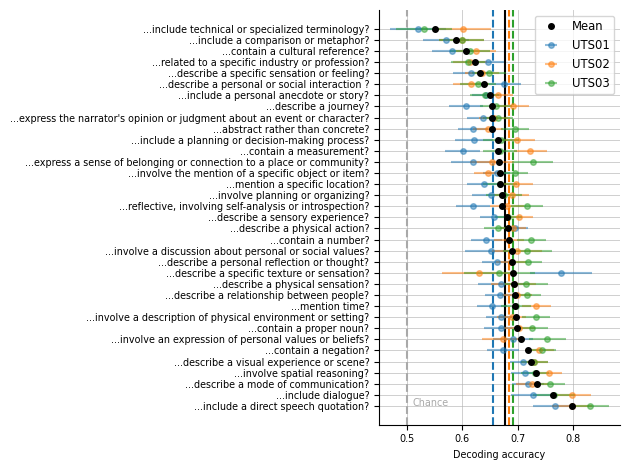

In [32]:
# plt.figure(figsize=(13, 13))
plt.figure(figsize=(8, 8))
fig, ax = plt.subplots()
colors = {
    'uts01': 'C0',
    'uts02': 'C1',
    'uts03': 'C2',
    'mean': 'black'
}
metric = 'test_acc'
# metric = 'test_acc_ood'
for subject in ['mean', 'uts01', 'uts02', 'uts03']:
    if subject == 'mean':
        dfs = [pd.read_pickle(join(data_dir, f'r_df_{subject}.pkl'))
               for subject in ['uts01', 'uts02', 'uts03']]
        r_df = pd.concat(dfs, axis=0).groupby('label').mean().reset_index()
        idx_sort = r_df[metric].sort_values(ascending=False).index
    else:
        r_df = pd.read_pickle(join(data_dir, f'r_df_{subject}.pkl'))

    r_df = r_df.loc[idx_sort]
    r_df = r_df[r_df['label'].isin(QS_35_STABLE)]

    # plot accuracy with binomial error bars
    if subject == 'mean':
        plt.errorbar(
            r_df[metric],
            range(len(r_df)),
            color='black',
            fmt='o',
            ms=4,
            zorder=1000,
            label=subject.capitalize(),
        )
        plt.axvline(r_df[metric].mean(), color=colors[subject])
    else:
        plt.errorbar(
            r_df[metric],
            range(len(r_df)),
            xerr=np.sqrt(
                r_df[metric] * (1-r_df[metric])
                / r_df['num_test']),
            alpha=0.5,
            label=subject.upper(),
            fmt='o',
            ms=4,
        )
        plt.axvline(r_df[metric].mean(),
                    linestyle='--', color=colors[subject])

    print('mean acc', r_df[metric].mean())

fs = 'x-small'
# add horizontal bars
labs = [analyze_helper.abbrev_question(q) for q in r_df['label']]
plt.yticks(range(len(r_df)), labs, fontsize=fs)
plt.xlabel(
    'Decoding accuracy', fontsize=fs)
plt.xticks(fontsize=fs)
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
# Get the current tick locations
xticks = ax.get_xticks()
yticks = ax.get_yticks()

# Select every other tick
# ax.set_xticks(xticks[::2])
ax.set_yticks(yticks[::2], minor=True)
ax.grid(True, which='major', linewidth=0.7, alpha=0.6)


# annotate with baseline and text label
plt.axvline(0.5, color='darkgray', linestyle='--')
plt.text(0.51, 0, 'Chance', color='darkgray', fontsize=fs, ha='left')
plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig('linear_decoding.png', dpi=300)
plt.show()

# Visualize learned coefs on cortex map

In [ ]:
subject = 'uts03'

In [ ]:
pca_comps = joblib.load(f'{subject}/pca_components.pkl')
# vertically stack pca_comps 4 times
pca_comps = np.vstack([pca_comps]*4)

In [ ]:
def quickshow(X: np.ndarray, subject="UTS03", fname_save=None, title=None):
    import cortex

    """
    Actual visualizations
    Note: for this to work, need to point the cortex config filestore to the `ds003020/derivative/pycortex-db` directory.
    This might look something like `/home/chansingh/mntv1/deep-fMRI/data/ds003020/derivative/pycortex-db/UTS03/anatomicals/`
    """
    vol = cortex.Volume(X, subject, xfmname=f"{subject}_auto")
    # , with_curvature=True, with_sulci=True)
    vabs = max(abs(vol.data.min()), abs(vol.data.max()))
    vol.vmin = -vabs
    vol.vmax = vabs
    # fig = plt.figure()
    # , vmin=-vabs, vmax=vabs)
    cortex.quickshow(vol, with_rois=True, cmap="PuBu")
    # fig = plt.gcf()
    # add title
    # fig.axes[0].set_title(title, fontsize='xx-small')
    if fname_save is not None:
        plt.savefig(fname_save)
        # plt.savefig(fname_save.replace(".pdf", ".png"))
        plt.close()

In [ ]:
for i in range(len(r_df)):
    pc_coef = r_df.iloc[i]['coef']
    voxel_coefs = (pc_coef @ pca_comps).squeeze()
    quickshow(voxel_coefs, fname_save=join(
        'flatmaps_decoding', f'{r_df.iloc[i]["label"]}.pdf'))